In [ ]:
# File: simple_dcgan.py

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from dataprepfunc import 
class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, image_size):
        super().__init__()
        self.label_emb = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 16 * 16)
        )
        self.init_size = 16
        self.fc = nn.Linear(noise_dim + 256, 128 * self.init_size * self.init_size)

        self.net = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z, y):
        y_emb = self.label_emb(y.float().view(-1, 1))
        z = torch.cat([z, y_emb], dim=1)
        out = self.fc(z)
        out = out.view(z.size(0), 128, self.init_size, self.init_size)
        img = self.net(out)
        img = nn.functional.interpolate(img, size=(167, 167))
        return img


class Discriminator(nn.Module):
    def __init__(self, label_dim, image_size):
        super().__init__()
        self.label_emb = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, image_size * image_size)
        )
        self.net = nn.Sequential(
            nn.Conv2d(2, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(128, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        y_emb = self.label_emb(y.float().view(-1, 1)).view(y.size(0), 1, image_size, image_size)
        x = torch.cat([x, y_emb], dim=1)
        out = self.net(x)
        return out.view(out.size(0), -1)


# Training and Sampling Functions
def train_dcgan(G, D, train_loader, noise_dim, device, epochs=30):
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

    G.train()
    D.train()

    for epoch in range(epochs):
        for real_imgs, labels in train_loader:
            real_imgs = real_imgs.to(device)
            labels = labels.to(device).long()
            batch_size = real_imgs.size(0)

            valid = torch.ones(batch_size, 1, device=device)
            fake = torch.zeros(batch_size, 1, device=device)

            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, noise_dim, device=device)
            gen_imgs = G(z, labels)
            validity = D(gen_imgs, labels)
            g_loss = criterion(validity, valid)
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            real_pred = D(real_imgs, labels)
            d_real_loss = criterion(real_pred, valid)
            fake_pred = D(gen_imgs.detach(), labels)
            d_fake_loss = criterion(fake_pred, fake)
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

        print(f"Epoch {epoch+1}/{epochs} | D loss: {d_loss.item():.4f} | G loss: {g_loss.item():.4f}")


def sample_dcgan(G, noise_dim, device, n_samples=8, label_value=0):
    G.eval()
    z = torch.randn(n_samples, noise_dim, device=device)
    labels = torch.full((n_samples,), label_value, dtype=torch.long, device=device)
    with torch.no_grad():
        samples = G(z, labels).cpu()
    samples = (samples + 1) / 2

    fig, axes = plt.subplots(1, n_samples, figsize=(n_samples * 2, 2))
    for i in range(n_samples):
        axes[i].imshow(samples[i].squeeze(), cmap='coolwarm')
        axes[i].axis('off')
    plt.show()


# Example Initialization
device = 'cuda' if torch.cuda.is_available() else 'cpu'
noise_dim = 100
image_size = 167
batch_size = 16
train_loader = load_dataset('train_data.pt', batch_size=batch_size, shuffle=True)
G = Generator(noise_dim, label_dim=1, image_size=image_size).to(device)
D = Discriminator(label_dim=1, image_size=image_size).to(device)
train_dcgan(G, D, train_loader, noise_dim, device, epochs=20)
sample_dcgan(G, noise_dim, device, n_samples=8, label_value=0)



Epoch 1/20 | D loss: 0.6597 | G loss: 0.7283
Epoch 2/20 | D loss: 0.6364 | G loss: 0.7556
Epoch 3/20 | D loss: 0.5979 | G loss: 0.8058
Epoch 4/20 | D loss: 0.5357 | G loss: 0.8884
Epoch 5/20 | D loss: 0.4325 | G loss: 1.0400
Epoch 6/20 | D loss: 0.3216 | G loss: 1.2930
Epoch 7/20 | D loss: 0.2447 | G loss: 1.4901


KeyboardInterrupt: 

Epoch 1/2 | D loss: 0.6600 | G loss: 0.7323
Epoch 2/2 | D loss: 0.6048 | G loss: 0.8025


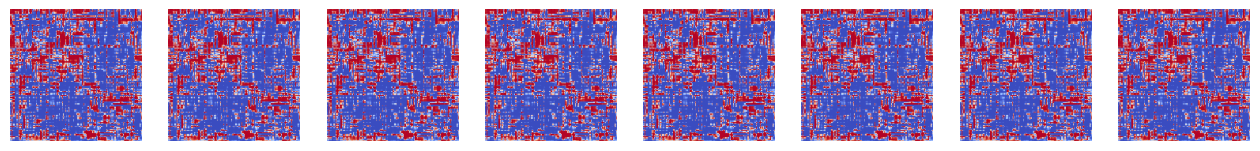

In [19]:
# File: simple_dcgan.py

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, image_size):
        super().__init__()
        self.label_emb = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 16 * 16)
        )
        self.init_size = 16
        self.fc = nn.Linear(noise_dim + 256, 128 * self.init_size * self.init_size)

        self.net = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z, y):
        y_emb = self.label_emb(y.float().view(-1, 1))
        z = torch.cat([z, y_emb], dim=1)
        out = self.fc(z)
        out = out.view(z.size(0), 128, self.init_size, self.init_size)
        img = self.net(out)
        img = nn.functional.interpolate(img, size=(167, 167))
        return img


class Discriminator(nn.Module):
    def __init__(self, label_dim, image_size):
        super().__init__()
        self.label_emb = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, image_size * image_size)
        )
        self.net = nn.Sequential(
            nn.Conv2d(2, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(128, 1, 1)
        )

    def forward(self, x, y):
        y_emb = self.label_emb(y.float().view(-1, 1)).view(y.size(0), 1, image_size, image_size)
        x = torch.cat([x, y_emb], dim=1)
        out = self.net(x)
        return out.view(out.size(0), -1)


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# Training and Sampling Functions
def train_dcgan(G, D, train_loader, noise_dim, device, epochs=10):
    criterion = nn.BCEWithLogitsLoss()
    optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

    G.apply(weights_init_normal)
    D.apply(weights_init_normal)

    G.train()
    D.train()

    for epoch in range(epochs):
        for real_imgs, labels in train_loader:
            real_imgs = real_imgs.to(device)
            labels = labels.to(device).long()
            batch_size = real_imgs.size(0)

            valid = torch.ones(batch_size, 1, device=device)
            fake = torch.zeros(batch_size, 1, device=device)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_pred = D(real_imgs, labels)
            d_real_loss = criterion(real_pred, valid)
            z = torch.randn(batch_size, noise_dim, device=device)
            gen_imgs = G(z, labels)
            fake_pred = D(gen_imgs.detach(), labels)
            d_fake_loss = criterion(fake_pred, fake)
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            validity = D(gen_imgs, labels)
            g_loss = criterion(validity, valid)
            g_loss.backward()
            optimizer_G.step()

        print(f"Epoch {epoch+1}/{epochs} | D loss: {d_loss.item():.4f} | G loss: {g_loss.item():.4f}")


def sample_dcgan(G, noise_dim, device, n_samples=8, label_value=0):
    G.eval()
    z = torch.randn(n_samples, noise_dim, device=device)
    labels = torch.full((n_samples,), label_value, dtype=torch.long, device=device)
    with torch.no_grad():
        samples = G(z, labels).cpu()
    samples = (samples + 1) / 2

    fig, axes = plt.subplots(1, n_samples, figsize=(n_samples * 2, 2))
    for i in range(n_samples):
        axes[i].imshow(samples[i].squeeze(), cmap='coolwarm')
        axes[i].axis('off')
    plt.show()


# Example Initialization
device = 'cuda' if torch.cuda.is_available() else 'cpu'
noise_dim = 100
image_size = 167
batch_size = 16
train_loader = load_dataset('train_data.pt', batch_size=batch_size, shuffle=True)
G = Generator(noise_dim, label_dim=1, image_size=image_size).to(device)
D = Discriminator(label_dim=1, image_size=image_size).to(device)
train_dcgan(G, D, train_loader, noise_dim, device, epochs=2)
sample_dcgan(G, noise_dim, device, n_samples=8, label_value=0)
